In [1]:
# Add scripts to path
import sys
sys.path.append('../scripts/')

# The ZINC.FL Chemical Space
_We hope that this notebook serves as a useful general guide as to the process of creating a mapper network of a particular chemical space_ 

## Introduction

Here we will use the Mapper algorithm to understand the chemical space of the ZINC.FL chemical library. This library consists of the _fragrance-like_ molecules of the ZINC database [[1,2](#references)]. A fragrance-like molecule is defined as one where:

1. Heavy Atom Count $<$ 21
2. Only C, H, O, S atoms
3. Number of Oxygens + Number of Sulphurs $\leq$ 3
4. Number of H-bond donors $\leq$ 1

The resulting subset, ZINC.FL, was developed in 2014, and can be found at [[3](#references)]. It consists of 37,661 molecules.

## Loading in Data
We have the structures in SMILES form [[3](#references)]. This is a many-to-one mapping from strings to molecular graphs (defined on the domain of this data set, we know this map is bijective). We load in the SMILES strings directly. The data is stored in `data/ZINC.FL.smi`, and consists of the SMILES strings and database identifiers.

<a id='references'>
## References
</a><br>
[1] Irwin, J.J., Sterling, T., Mysinger, M.M., Bolstad, E.S., Coleman, R.G. -- Zinc: A Free Tool to Discover Chemistry for Biology, _J. Chem. Inf. Model._, __2012__, 52, 1757-1768 <br>
[2] Zinc Database can be found at: [Zinc](http://zinc.docking.org) <br>
[3] Ruddigkeit, L., Awale, M., Reymond, J., Expanding the fragrance chemical space for virtual screening, _Journal of Cheminformatics_, __2014__, 6 <br>
[4] Morgan, H.: The Generation of a Unique Machine Description for Chemical Structures-A Technique Developed at Chemical Abstracts Service, _Journal of Chemical Documentation_, __1965__, 5, 107-113 <br>
[5] Rogers, D., Hahn, M.: Extended Connectivity Fingerprints, _J. Chem. Inf. Model_, __2010__, 50, 742-752 <br>
[6] Wildman, S.A., Crippen, G.M.: Prediction of Physicochemical Parameters by Atomic Contributions, _J. Chem. Inf. Comput. Sci._, __1999__ 35, 868-873<br>
[7] Bertz, S.: The first general index of molecular complexity, _J. Am. Chem. Soc._, __1981__, 103, 3599-3601 <br>
[8] Landrum, G.: [RDKit: Open-Source Cheminformatics](http://rdkit.org) <br>
[9] Baldi, P., Nasr, R.: When is Chemical Similarity Significant?..., _J. Chem. Inf. Model._, __2011__, 50, 1205-1222 <br>

In [2]:
import pandas as pd

ZINC_FL = pd.read_csv('../data/ZINC.FL/ZINC.FL.smi', sep=' ', header=0, names=['SMILES', 'DB_ID'])

n_molecules = len(ZINC_FL)

## Calculation of Fingerprints and Descriptors

In this work, our chemical space of interest is that defined by the Morgan fingerprints [[4](#references)]. In practice, this is similar to the commonly used ECFP fingerprints [[5](#references)]. For this work, we will use a radius of $2$ (similar to the ECFP4 class of fingerprint).

We use the fingerprint representation of our molecules as it induces an easy-to-calculate metric between them. The fingerprints are binary strings, and therefore we define the Tanimoto (Jaccard) similarity $T(A,B)$, and its associated distance $d(A,B)$ in the usual way:

$T(A,B) = \frac{A\bigcap B}{A\bigcup B}$ and $d(A,B) = 1-T(A,B)$

We will also calculate some basic molecular descriptors. We want these properties to be determined entirely from the molecular graph, and to therefore be independent of conformation and stereoisomerism. These properties are as follows:

1. `n_atom`: The number of (non-hydrogen) atoms
2. `n_ring`: The number of rings
3. `n_aro`: The number of aromatic rings
4. `n_rot`: The number of rotatable bonds
    1. We are strict in our defition of a rotatable bond here.
5. `MW`: The molecular weight
6. `LogP`: The octanol-water partition coefficient
    1. This is calculated using the Atom-based scheme found in [[6](#references)]
7. `Bertz`: The Bertz coefficient
    1. This is meant to quantify molecular complexity, more details in [[7](#references)]. 
8. `n_O`: Number of Oxygen atoms
9. `n_S`: Number of Sulphur atoms
10. `n_P`: Number of Phosphorus atoms


The fingerprint and descriptors are all calculated using the RDKit library [[8](#references)]

In [3]:
import numpy as np
from rdkit.Chem.rdMolDescriptors import CalcNumRings, CalcNumAromaticRings, CalcNumRotatableBonds
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, GetMorganFingerprintAsBitVect, NumRotatableBondsOptions
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.GraphDescriptors import BertzCT
from rdkit.Chem import MolFromSmiles
from rdkit import DataStructs
from ipywidgets import FloatProgress, HBox, Label
from IPython.display import display

def findCounts(s, ch):
    # Find number of times an element is in a smiles string. 
    # v.v. basic - Works for S, O, P etc, when we know nothing weird will be present
    # ignores aromaticity - always search for an uppercase string
    return len([letter for letter in s if letter.upper() == ch])

# Set up array to put fingerprints into
nBits = 512
useFeatures = False # Set this to true if we want to create fingerprints analogous to FCFP rather than ECFP
r = 2
fp_arr = np.zeros((n_molecules, nBits))

# Set up array to put descriptors into
desc_names = ['n_atom', 'n_ring', 'n_aro', 'n_rot', 'MW', 'LogP', 'Bertz', 'n_O', 'n_S', 'n_P']
n_descs = len(desc_names)
desc_arr = np.zeros((n_molecules, n_descs))
strictness = NumRotatableBondsOptions.StrictLinkages

# Set up progress bar
progressbar = FloatProgress(min=0, max=n_molecules, bar_style='success')
progressbox = HBox([Label('Calculation Progress'), progressbar])
display(progressbox)

for smiles_i, smiles in enumerate(ZINC_FL['SMILES']):
    
    # Create Molecule Object
    molecule = MolFromSmiles(smiles)
    
    ### Descriptor calculation
    desc_arr[smiles_i, 0] = molecule.GetNumHeavyAtoms()
    desc_arr[smiles_i, 1] = CalcNumRings(molecule)
    desc_arr[smiles_i, 2] = CalcNumAromaticRings(molecule)
    desc_arr[smiles_i, 3] = CalcNumRotatableBonds(molecule, strict=strictness)
    desc_arr[smiles_i, 4] = CalcExactMolWt(molecule)
    desc_arr[smiles_i, 5] = MolLogP(molecule)
    desc_arr[smiles_i, 6] = BertzCT(molecule)
    desc_arr[smiles_i, 7] = findCounts(smiles, 'O') 
    desc_arr[smiles_i, 8] = findCounts(smiles, 'S')
    desc_arr[smiles_i, 9] = findCounts(smiles, 'P')
    
    
    ### Fingerprint calculation
    fingerprint = GetMorganFingerprintAsBitVect(molecule, r, nBits=nBits, useFeatures=useFeatures)
    
    #Put it into the fingerprint array
    arr = np.zeros((1,nBits),dtype='bool')
    DataStructs.ConvertToNumpyArray(fingerprint,arr)
    fp_arr[smiles_i] = arr
    
    # Tick up progressbar
    progressbar.value += 1

### Creation of Image Tooltips

One of the features of KeplerMapper is the potential to use images as tooltips for the Cluster Details pane. Using RDKit, we are able to create images of the skeletal structures of the molecules. We will use these as tooltips.

> Using these tooltips causes the size of the output `.html` file to increase dramatically. It is therefore suggested that these tooltips are not used in every network visualisation.

In [4]:
from rdkit.Chem import Draw
import io
import base64
import numpy as np
from scipy.misc import toimage, imsave, imresize

### THIS FUNCTION TECHNICALLY APPEARS IN SCRIPTS --- We put it here in full.

def smi2image(smiles, size=300):
    """Turn a smiles string into an image"""
    molecule = MolFromSmiles(smiles)
    return Draw.MolToImage(molecule, size=[size,size])

# Set up progress bar
progressbar = FloatProgress(min=0, max=n_molecules, bar_style='success')
progressbox = HBox([Label('Calculation Progress'), progressbar])
display(progressbox)

tooltips = []
for smiles_i, smiles in enumerate(ZINC_FL['SMILES']):
    output = io.BytesIO()
    img = toimage(smi2image(smiles))
    img.save(output, format='PNG')
    contents = output.getvalue()
    img_encoded = base64.b64encode(contents)
    img_tag = """<p>
                 <div style="width:300px;
                            height:300px;
                            overflow:hidden;
                            float:left;
                            position:relative;">
                 <img src="data:image/png;base64,%s" style="position:absolute; top:0; right:0;
                                                            width: 300px; height: 300px;" />
                 </div>
                 </p>""" % (img_encoded.decode('utf-8'))
    tooltips.append(img_tag)
    progressbar.value += 1
tooltips = np.array(tooltips)

## Distribution of Tanimoto distances

When using the DBScan algorithm, the parameter `eps` defines the maximum distance between two samples for them to be considered as in the same neighborhood. If this parameter is set too high, the consequence for the mapper algorithm is that each patch within the cover is one cluster. Therefore, it is useful to know the distribution of the Tanimoto distance between molecules, to choose a sensible value for `eps`.

For this dataset, it is impractical to calculate the pairwise distance for all pairs of molecules. Therefore, we will select a molecule at random, and compute its distance to all other molecules in the set. We will do this several times, and spot patterns.

In general, a good article discussing this can be found in [[9](#references)]

> The choice of clusterer is one of Mapper's hyperparameters. Other clusterers are available, KeplerMapper requires that they match the scikit-learn API.

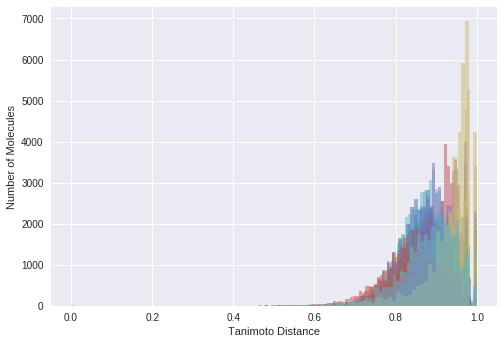

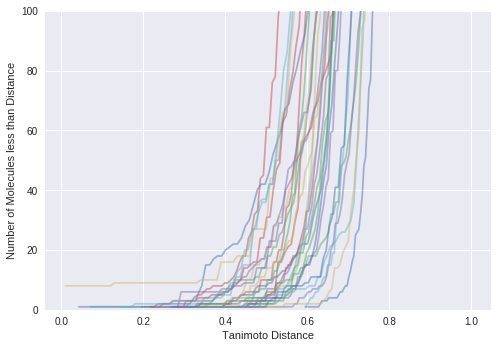

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings(action='ignore')

n_samples = 30

molecule_indices = np.arange(n_molecules)

# Plotting objects
hist = plt.figure()
histax = hist.add_subplot(111)
cumsum = plt.figure()
cumsumax = cumsum.add_subplot(111)

np.random.seed(42)
for sample_n in range(n_samples):
    choice_molecule = np.random.choice(molecule_indices)
    mask = np.ones(n_molecules, dtype=bool)
    mask[choice_molecule] = False
    distances = pairwise_distances(fp_arr[choice_molecule].reshape(1,-1), fp_arr[mask], metric='jaccard')
    histvals = histax.hist(distances.flatten(), bins=100, normed=False, alpha=0.5)
    
    cumsumvals = histvals[0].cumsum()
    cumsumax.plot(histvals[1][1:],cumsumvals, alpha=0.5)

n_nearest_cutoff = 100
cumsumax.set_ylim([0,n_nearest_cutoff])
cumsumax.set_xlabel('Tanimoto Distance')
cumsumax.set_ylabel('Number of Molecules less than Distance')
histax.set_xlabel('Tanimoto Distance')
histax.set_ylabel('Number of Molecules')
plt.show()

### Comments
Most molecules are within a distance of 0.65 to their 10 nearest neighbors. This seems like a reasonable value for `eps`.


## Creation of Lens

Before we use the mapper algorithm, we must define a lens. For this work, we will use a 2-dimensional PCA as our projection. This is relatively computationally cheap, compared to something like T-SNE. We will also plot this projection, colored by ring count. Lastly, we produce a plot showing how the (now $L_2$) distances have changed as a result of this projection.

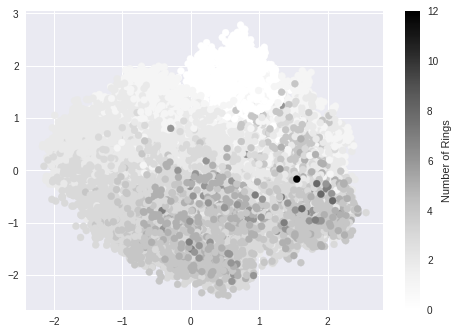

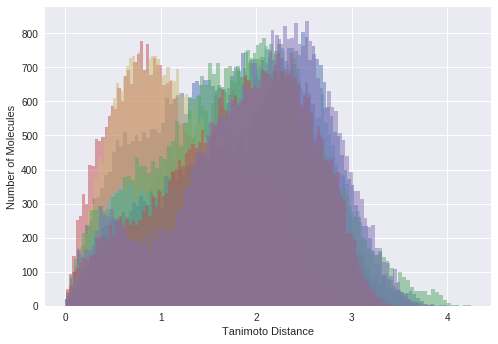

In [12]:
from sklearn.decomposition import PCA

# Calculate lens
pca = PCA(n_components=2)
lens = pca.fit_transform(fp_arr)

# Plot it
plt.scatter(lens[:,0], lens[:,1], c=desc_arr[:,1])
cbar = plt.colorbar()
cbar.set_label('Number of Rings')
plt.show()


hist = plt.figure()
histax = hist.add_subplot(111)

np.random.seed(42)
n_samples=10
for sample_n in range(n_samples):
    choice_molecule = np.random.choice(molecule_indices)
    mask = np.ones(n_molecules, dtype=bool)
    mask[choice_molecule] = False
    distances = pairwise_distances(lens[choice_molecule].reshape(1,-1), lens[mask], metric='l2')
    histvals = histax.hist(distances.flatten(), bins=100, normed=False, alpha=0.5)
histax.set_xlabel('Tanimoto Distance')
histax.set_ylabel('Number of Molecules')
plt.show()

Clearly, performing this projection has changed the distribution of distances. This is actually one of the strengths of the mapper algorithm - we can perform our clustering using the distances of the original space, which rectifies some of the projection error.

In [23]:
import kmapper as km
from sklearn.cluster import DBSCAN

#### MAPPER HYPERPARAMETERS
n_cubes = [30,30]
perc_overlap = 0.4
cover = km.cover.Cover(n_cubes, perc_overlap)

### SAVED PARAMS
eps = 0.65
min_samples = 4

metric = 'jaccard'
clusterer = DBSCAN(metric=metric, eps=eps, min_samples=min_samples, n_jobs=1)

### RANDOM SEED - useful for stochastic clustering method
random_seed = 42
np.random.seed(random_seed)

### MAPPER
mapper = km.KeplerMapper(verbose=1)
network = mapper.map(lens=lens,
                     X=fp_arr,
                     clusterer=clusterer,
                     cover=cover,
                     precomputed=False)

# Make a color function where it is colored by the number of atoms in the molecule
c_f = desc_arr[:,0]

_ = mapper.visualize(network,
                 title='ZINC.FL: Mapper Network',
                 color_function=c_f,
                 path_html='networks/ZINC-FL_space/network.html',
                 custom_tooltips = tooltips,
                 custom_meta={'Color': 'Number of Atoms'})


KeplerMapper()
Mapping on data shaped (37660, 512) using lens shaped (37660, 2)

Creating 900 hypercubes.

Created 3561 edges and 1351 nodes in 0:00:24.537011.
Wrote visualization to: networks/ZINC-FL_space/network.html


## Visualisation

> This works best when using the notebook in Chrome. It does not work for GitHub's notebook viewer.

In [19]:
from kmapper.jupyter import display

display(path_html='networks/ZINC-FL_space/network.html')